In [1]:
import numpy as np
import scipy as sp
from scipy import integrate, interpolate
import scipy.fft as fft
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import h5py
import os
import time

Global Parameters

In [2]:
# Global Rocket Parameters
xi = 50
Gmu = 1e-12
GammaFrac = 0.1
vf = 0.3
nRockets = 10

# Global Simulation Parameters
tmax = 100
L = 100
binS = 100
zi = 127
dx = L / binS
h = 0.7
rhoScale = 4.78e-20 # Mpc / Msun

# Global Physical Parameters
t0 = 4213 / h # Mpc / h
H0 = 0.0003333

In [3]:
# Cluster dirs
homeDir = "C:\\Users\\NeilShah\\Documents\\PhD\\Rocket Capture\\"
simName = "Sim_100v"
simDir = homeDir + simName + "\\"

Utility Functions

In [6]:
def getHubbleEvol():
    OMatter = 0.25
    OLambda = 0.75

    da_dt = lambda a, t: a * H0 * np.sqrt(OMatter / a**3 + OLambda)

    a0 = 1 / (1 + zi)
    tInt = np.linspace(0, 1.1 / H0, 1000)
    af = interpolate.InterpolatedUnivariateSpline(tInt, integrate.odeint(da_dt, y0=a0, t=tInt)[:, 0])
    aDotf = af.derivative(n=1)
    tEnd = sp.optimize.fsolve(lambda t: af(t) - 1.0, x0=(1.0 / H0))[0]

    tArr = np.asarray([(tEnd + t)**(t / tmax) - 1 for t in range(tmax)])
    aArr = np.asarray([af(t) for t in tArr])
    HArr = np.asarray([aDotf(t) / af(t) for t in tArr])

    return tArr, aArr, HArr

In [83]:
def getFg(t, pos, rhokL):
    x, y, z = list(map(int, np.floor(pos)))
    kArr = getkArr()
    phix = fft.fftn(rhokL).real

    Fg = (4*np.pi / (2*dx)) * np.asarray([phix[x + 1, y, z] - phix[x - 1, y, z], phix[x, y + 1, z] - phix[x, y - 1, z], phix[x, y, z + 1] - phix[x, y, z - 1]])
    return(Fg)


print(getFg(50, [50, 50, 50], getRhokLambda(50, getkArr())))
print((H0 * GammaFrac / xi))

[ 1.95667223e-07 -2.14587864e-07 -2.23938410e-08]
6.666e-07


In [16]:
def getkArr(override=False):
    kArrPath = simDir + "kArr__bins_{:03d}.npy".format(binS)
    if os.path.exists(kArrPath) and not override:
        kArr = np.load(kArrPath)
        return(kArr)

    kArr = np.zeros((binS, binS, binS), dtype=float)
    halfBins = int(binS / 2)
    for i in range(binS):
        for j in range(binS):
            for k in range(binS):
                lx = - (4 * binS**2 / L**2) * np.sin((np.pi / binS) * (i - halfBins))**2
                ly = - (4 * binS**2 / L**2) * np.sin((np.pi / binS) * (j - halfBins))**2
                lz = - (4 * binS**2 / L**2) * np.sin((np.pi / binS) * (k - halfBins))**2
                if i == halfBins and j == halfBins and k == halfBins:
                    kArr[i, j, k] = 1
                else:
                    kArr[i, j, k] = lx + ly + lz
    
    np.save(kArrPath, kArr)
    return kArr

def getRhokLambda(t, kArr):
    rhox = getRhox(t)
    rhok = fft.ifftn(rhox)

    halfBins = int(binS / 2)
    rhokL = np.divide(rhok, kArr)
    rhokL[halfBins, halfBins, halfBins] = 0
    
    return(rhokL)

In [27]:
def getRhox(t, override=False):
    saveDir = homeDir + simName + "_rhoX\\"
    if not os.path.exists(saveDir):
        os.makedirs(saveDir)
    savePath = saveDir + "rhoX_test_{:d}.npy".format(t)

    if os.path.exists(savePath) and not override:
        rhox = np.load(savePath)
        return(rhox)
    else:
        snapDir = simDir + "snapdir_{:03d}\\".format(t)
        pathArr = np.asarray(os.listdir(snapDir))
        
        ptypeN = 3
        massArr = getMass()
        rhox = np.zeros((binS, binS, binS))
        for pi in np.arange(0, ptypeN):
            ptype = pi + 1
            mi = massArr[pi]
            
            for pathi in np.arange(0, pathArr.size):
                datGet = "/PartType{:d}/Coordinates".format(ptype)
                try:
                    coords = np.asarray(h5py.File(snapDir + pathArr[pathi], 'r')[datGet])
                except KeyError:
                    # print("   (Warning! Could not find ptype {:d} for snapshot t = {:d})".format(ptype, t))
                    pass

                for ci, coord in enumerate(coords):
                    i, j, k = list(map(lambda x: x - 1 if x == binS else x, map(int, np.floor(coord))))
                    rhox[i, j, k] += mi
        
        rhox *= rhoScale * 1e10
        np.save(savePath, rhox)
        return(rhox)

def rhoInstantiate(redo=[]):
    t0 = time.time()
    override = False
    for t in range(0, tmax):
        catch = getRhox(t, override=False)
        if np.mod(t, 10) == 0:
            print("   Processing t = {}/{} (Time Elapsed: {}, Estimated Time Remaining: {})".format(t + 1, tmax, toMS(time.time() - t0), toMS((tmax / (t + 1) - 1) * (time.time() - t0))))
    
    print("Finished Instantiating Density Matrices! Took: {}\n".format(toMS(time.time() - t0)))

In [18]:
def getMass():
    tFix = 50
    massTab = np.zeros(3)

    snapDir = simDir + "snapdir_{:03d}\\".format(tFix)
    path1 = snapDir + "snapshot_{:03d}.0.hdf5".format(tFix)
    fil = h5py.File(path1, 'r')

    ptypeN = 3
    for pi in np.arange(0, ptypeN):
        ptype = pi + 1
        datGet = "/PartType{:d}/Masses".format(ptype)
        massTab[pi] = np.asarray(fil[datGet])[0]

    return massTab

In [19]:
def toMS(t):
    s = np.floor(np.mod(t, 60))
    m = np.floor(np.mod(t, 3600) / 60)
    h = np.floor(t / 3600)

    if t < 1:
        tstr = "{:f} s".format(t)
    elif t < 3600:
        tstr = "{:02d}m {:02d}s".format(int(m), int(s))
    else:
        tstr = "{}h {:02d}m {:02d}s".format(int(h), int(m), int(s))
    return tstr

In [5]:
def getHaloC(t):
    haloFinalDir = simDir + "snapdir_{:03d}/".format(t)
    pathArr = np.asarray(os.listdir(haloFinalDir))
    haloFinalCoords = np.empty((0, 3))

    for pathi in np.arange(0, pathArr.size):
        datGet = "/PartType1/Coordinates"
        try:
            coords = np.asarray(h5py.File(haloFinalDir + pathArr[pathi], 'r')[datGet])
        except KeyError:
            continue
        haloFinalCoords = np.concatenate([haloFinalCoords, coords], axis=0)

    haloC = np.asarray([np.mean(haloFinalCoords[:, i]) for i in range(3)])
    return(haloC)

def getRVir():
    snapDir = simDir + "groups_100\\"
    file = h5py.File(snapDir + "fof_subhalo_tab_100.0.hdf5", 'r')

    RVir200 = np.asarray(file["/Group/Group_R_Crit200"])[0]
    RVir500 = np.asarray(file["/Group/Group_R_Crit500"])[0]
    return RVir200, RVir500

In [31]:
snapDir = simDir + "snapdir_050\\"
file = h5py.File(snapDir + "snapshot_050.0.hdf5", 'r')
print(file.keys())
print(file["Header"])

<KeysViewHDF5 ['Config', 'Header', 'Parameters', 'PartType1', 'PartType2', 'PartType3']>
<HDF5 group "/Header" (0 members)>


In [7]:
snapDir = simDir + "groups_100\\"
file = h5py.File(snapDir + "fof_subhalo_tab_100.0.hdf5", 'r')
print(file.keys())
print(file["Group"].keys())

<KeysViewHDF5 ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']>
<KeysViewHDF5 ['GroupAscale', 'GroupFirstSub', 'GroupLen', 'GroupLenType', 'GroupMass', 'GroupMassType', 'GroupNsubs', 'GroupOffsetType', 'GroupPos', 'GroupVel', 'Group_M_Crit200', 'Group_M_Crit500', 'Group_M_Mean200', 'Group_M_TopHat200', 'Group_R_Crit200', 'Group_R_Crit500', 'Group_R_Mean200', 'Group_R_TopHat200']>


Rocket Evolution

In [28]:
t0G = time.time()
print("Hello! Now Beginning Rocket Evolution")
print("This run has Global Parameters: xi = {}, Gmu = {}, GammaFrac = {}, vf = {}\n".format(xi, Gmu, GammaFrac, vf))

print("Now Beginning Instantiation of rho matrices. Here I will calculate binned density matrices from the raw simulation data and save it to a file.")
rhoInstantiate()

# Get Hubble Evolution
tArr, aArr, HArr = getHubbleEvol()
dtArr = np.diff(tArr)

Hello! Now Beginning Rocket Evolution
This run has Global Parameters: xi = 50, Gmu = 1e-12, GammaFrac = 0.1, vf = 0.3

Now Beginning Instantiation of rho matrices. Here I will calculate binned density matrices from the raw simulation data and save it to a file.
   Processing t = 1/100 (Time Elapsed: 0.006019 s, Estimated Time Remaining: 0.595892 s)
   Processing t = 11/100 (Time Elapsed: 0.079791 s, Estimated Time Remaining: 0.645578 s)
   Processing t = 21/100 (Time Elapsed: 0.145612 s, Estimated Time Remaining: 0.547777 s)
   Processing t = 31/100 (Time Elapsed: 0.214427 s, Estimated Time Remaining: 0.477273 s)
   Processing t = 41/100 (Time Elapsed: 0.281248 s, Estimated Time Remaining: 0.404723 s)
   Processing t = 51/100 (Time Elapsed: 0.352060 s, Estimated Time Remaining: 0.338254 s)
   Processing t = 61/100 (Time Elapsed: 0.410901 s, Estimated Time Remaining: 0.262707 s)
   Processing t = 71/100 (Time Elapsed: 0.467750 s, Estimated Time Remaining: 0.191053 s)
   Processing t = 8

In [42]:
print("\nNow Processing Rocket Evolution!:")
rocketSavePath = simDir + "loopEvol__num_{:d}__xi_{:d}.npy".format(nRockets, xi)

xArr = np.zeros((nRockets, 3, tmax))
vArr = np.zeros((nRockets, 3, tmax))

# xArr[:, :, 0] = np.asarray([L * np.random.rand(3) for i in range(0, nRockets)])
xArr[:, :, 0] = np.asarray([[42, 42, 42] + np.random.rand(3) for i in range(0, nRockets)])
vArr[:, :, 0] = 2.6 * (1 + zi) * np.sqrt(xi * Gmu) * vf * np.asarray([v / np.linalg.norm(v) for v in np.random.rand(nRockets, 3)])

kArr = getkArr()
t0 = time.time()
for ti in np.arange(0, tmax - 1):
    t = tArr[ti]
    dti = dtArr[ti]
    ai = aArr[ti]
    Hi = HArr[ti]
    rhokLi = getRhokLambda(ti, kArr)
    
    for ri in range(nRockets):
        if ti == round(tmax / 2): print([Fgi, dti, ai])
        Fgi = getFg(ti, xArr[ri, :, ti], rhokLi)
        vArr[ri, :, ti + 1] = vArr[ri, :, ti] - 2 * Hi * vArr[ri, :, ti] * dti + (dti / ai) * Fgi
        xArr[ri, :, ti + 1] = xArr[ri, :, ti] + dti * vArr[ri, :, ti]
    
    if np.mod(ti, 10) == 0:
        print("   Processing t = {}/{} (Time Elapsed: {}, Estimated Time Remaining: {})".format(ti + 1, tmax, toMS(time.time() - t0), toMS((tmax / (ti + 1) - 1) * (time.time() - t0))))

print("Finished Processing Rocket Evolution! Time Taken: {}\n".format(toMS(time.time() - t0)))

np.save(rocketSavePath, np.asarray([xArr, vArr]))
print("Rocket Trajectories Successfully Exported. \nWe are now done, thank you! Total Time Taken: {}\n".format(toMS(time.time() - t0G)))


Now Processing Rocket Evolution!:
   Processing t = 1/100 (Time Elapsed: 0.684972 s, Estimated Time Remaining: 01m 07s)
   Processing t = 11/100 (Time Elapsed: 00m 05s, Estimated Time Remaining: 00m 46s)
   Processing t = 21/100 (Time Elapsed: 00m 10s, Estimated Time Remaining: 00m 40s)
   Processing t = 31/100 (Time Elapsed: 00m 15s, Estimated Time Remaining: 00m 34s)
   Processing t = 41/100 (Time Elapsed: 00m 20s, Estimated Time Remaining: 00m 29s)
[array([ 4.39442120e-07, -6.00984110e-07,  1.05207751e-06]), 4.660305781538135, 0.059011301842633035]
[array([ 4.28842511e-07, -2.92660669e-07,  6.84376983e-07]), 4.660305781538135, 0.059011301842633035]
[array([ 4.28842511e-07, -2.92660669e-07,  6.84376983e-07]), 4.660305781538135, 0.059011301842633035]
[array([ 4.28842511e-07, -2.92660669e-07,  6.84376983e-07]), 4.660305781538135, 0.059011301842633035]
[array([ 4.28842511e-07, -2.92660669e-07,  6.84376983e-07]), 4.660305781538135, 0.059011301842633035]
[array([ 4.28842511e-07, -2.92660

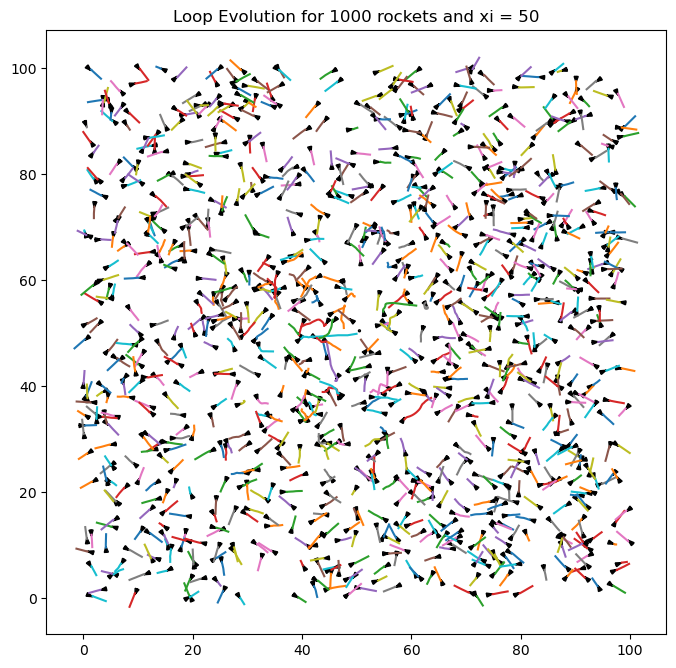

In [53]:
xArr, vArr = np.load(homeDir + "loopEvol__num_1000__xi_50.npy")
haloC = getHaloC(tmax)
RVir200, RVir500 = getRVir()

fig = plt.figure(1, figsize=(8, 8), dpi=100)
ax = fig.gca() 
virCirc = plt.Circle((haloC[0], haloC[1]), RVir200, fill=False)
ax.add_patch(virCirc)

[plt.plot(xArr[i, 0, :], xArr[i, 1, :]) for i in range(xArr.shape[0])]
for i in range(xArr.shape[0]):
    xc = xArr[i, 0, 0]
    yc = xArr[i, 1, 0]
    dxA = xArr[i, 0, 51]-xArr[i, 0, 50]
    dyA = xArr[i, 1, 51]-xArr[i, 1, 50]
    plt.arrow(xc, np.mean(xArr[i, 1, :]), dxA, dyA, shape="full", length_includes_head=True, head_width=0.75)
plt.title("Loop Evolution for {} rockets and xi = {}".format(1000, 50))
plt.savefig(homeDir + "loopEvol__num_1000__xi_50" + ".png", dpi=300)
plt.show()

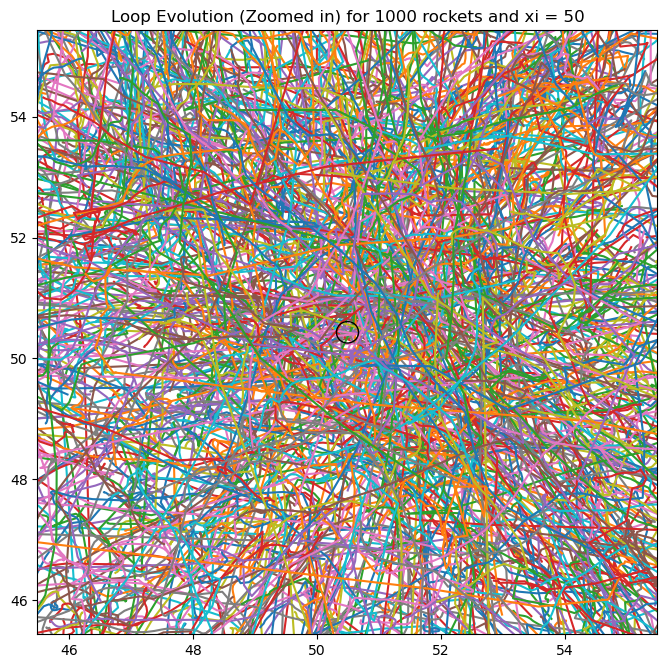

In [26]:
xArr, vArr = np.load(homeDir + "loopEvol_ZoomedIn__num_1000__xi_50.npy")
haloC = getHaloC(tmax)
RVir200, RVir500 = getRVir()
meanPath = 5.0

fig = plt.figure(2, figsize=(8, 8), dpi=100)
ax = fig.gca() 
virCirc = plt.Circle((haloC[0], haloC[1]), RVir200, fill=False, zorder=10)

pltN = xArr.shape[0]
[plt.plot(xArr[i, 0, :], xArr[i, 1, :]) for i in range(pltN)]
plt.xlim([haloC[0] - meanPath, haloC[0] + meanPath])
plt.ylim([haloC[1] - meanPath, haloC[1] + meanPath])
plt.title("Loop Evolution (Zoomed in) for {} rockets and xi = {}".format(1000, 50))
ax.add_patch(virCirc)
plt.savefig(homeDir + "loopEvol_ZoomedIn__num_1000__xi_50" + ".png", dpi=300)
plt.show()


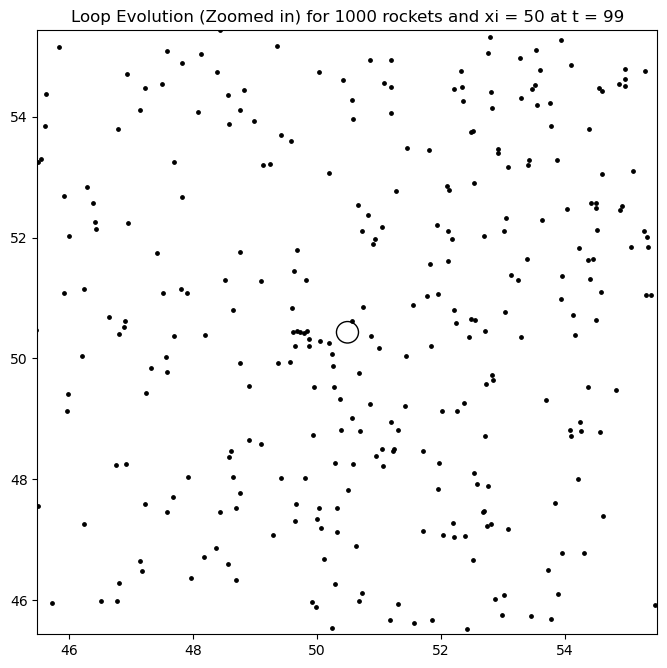

In [57]:
fig3 = plt.figure(3, figsize=(8, 8), dpi=100)
ax3 = fig3.gca()
tEv = tmax-1
ax3.scatter(xArr[:, 0, tEv], xArr[:, 1, tEv], c='k', s=6)
plt.xlim([haloC[0] - meanPath, haloC[0] + meanPath])
plt.ylim([haloC[1] - meanPath, haloC[1] + meanPath])
plt.title("Loop Evolution (Zoomed in) for {} rockets and xi = {} at t = {}".format(1000, 50, tEv))
ax3.add_patch(plt.Circle((haloC[0], haloC[1]), RVir200, fill=False, zorder=10))
plt.savefig(homeDir + "loopEvol_ZoomedIn__t_{}__num_1000__xi_50".format(tEv) + ".png", dpi=300)
plt.show()

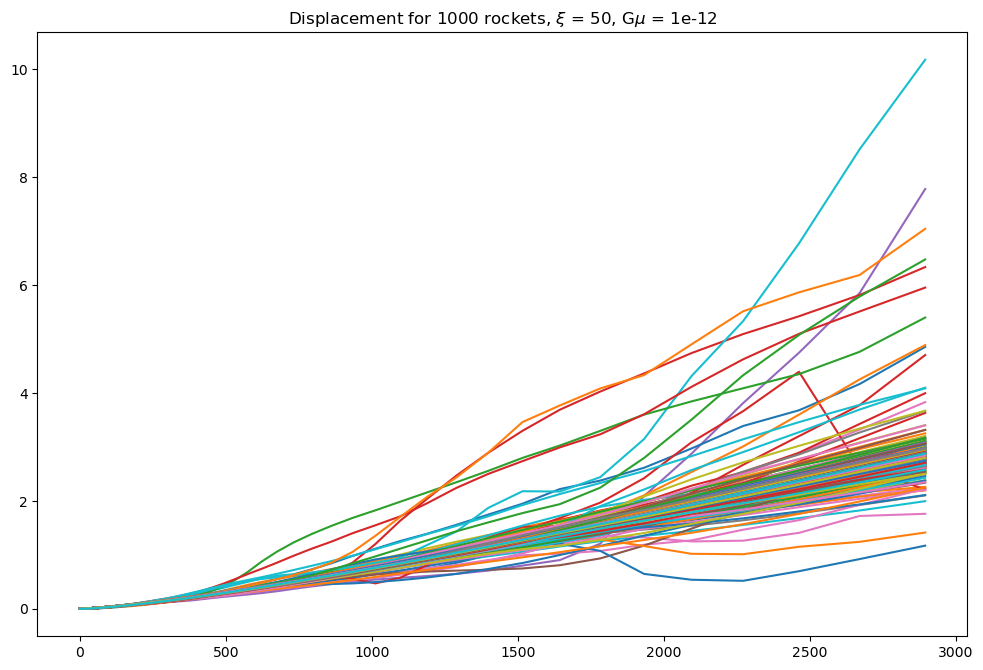

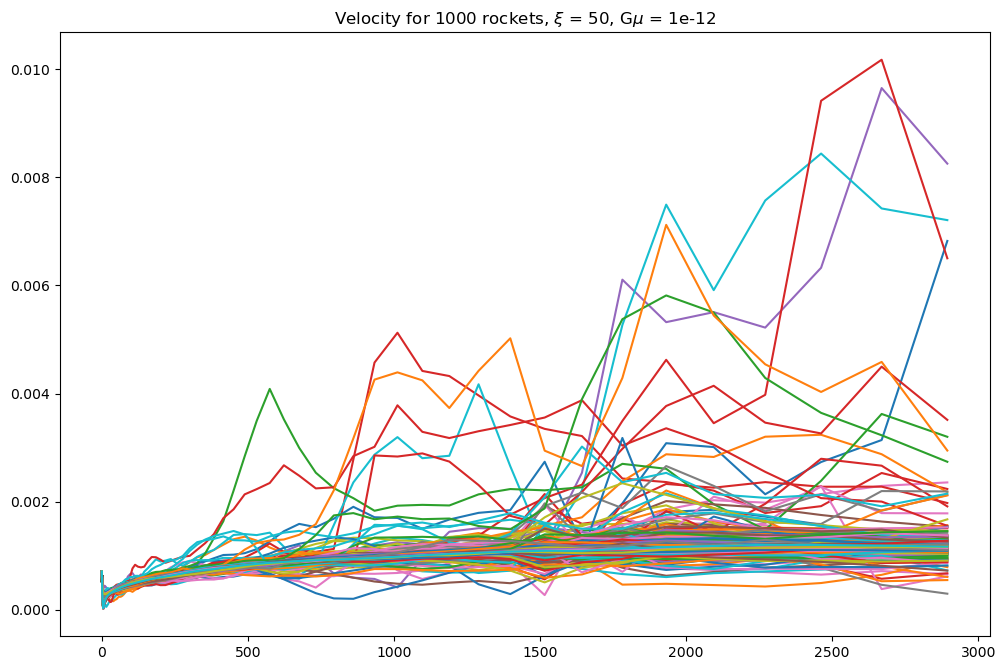

In [29]:
xArr, vArr = np.load(homeDir + "loopEvol__num_1000__xi_50.npy")
tArr, aArr, HArr = getHubbleEvol()
haloC = getHaloC(tmax)
RVir200, RVir500 = getRVir()

fig = plt.figure(4, figsize=(12, 8), dpi=100)
ax = fig.gca()

[plt.plot(tArr, [np.linalg.norm(xArr[i, :, t] - xArr[i, :, 0]) for t in range(tmax)]) for i in range(xArr.shape[0])]
plt.title(r"Displacement for {} rockets, $\xi$ = {}, G$\mu$ = {}".format(1000, 50, Gmu))
# plt.savefig(homeDir + "loopEvol__num_1000__xi_50" + ".png", dpi=300)
plt.show()

fig = plt.figure(5, figsize=(12, 8), dpi=100)
ax = fig.gca()

[plt.plot(tArr, [np.linalg.norm(vArr[i, :, t]) for t in range(tmax)]) for i in range(xArr.shape[0])]
plt.title(r"Velocity for {} rockets, $\xi$ = {}, G$\mu$ = {}".format(1000, 50, Gmu))
# plt.savefig(homeDir + "loopEvol__num_1000__xi_50" + ".png", dpi=300)
plt.show()

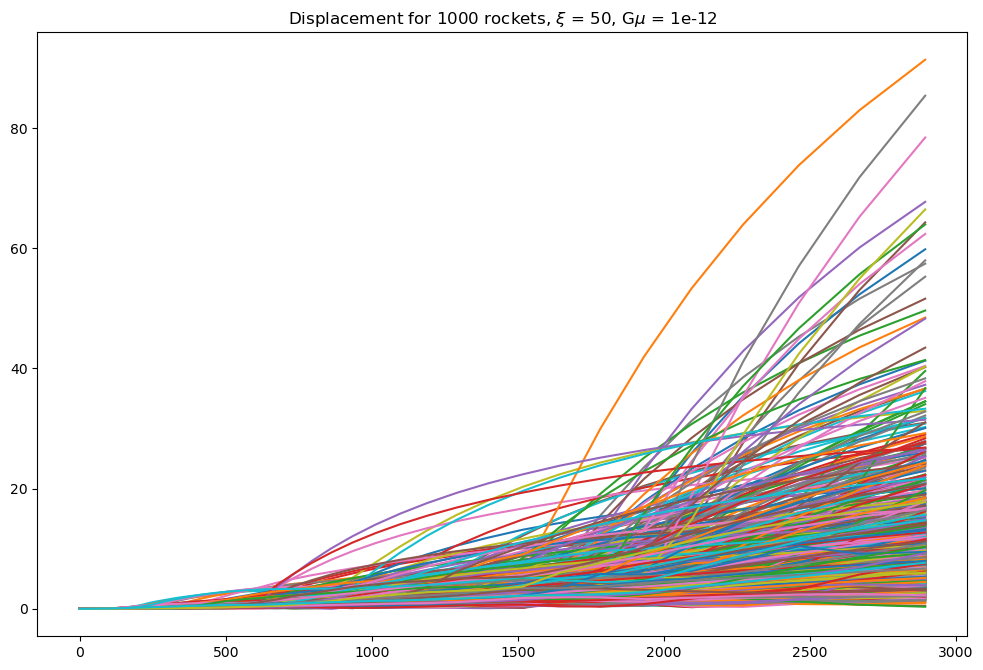

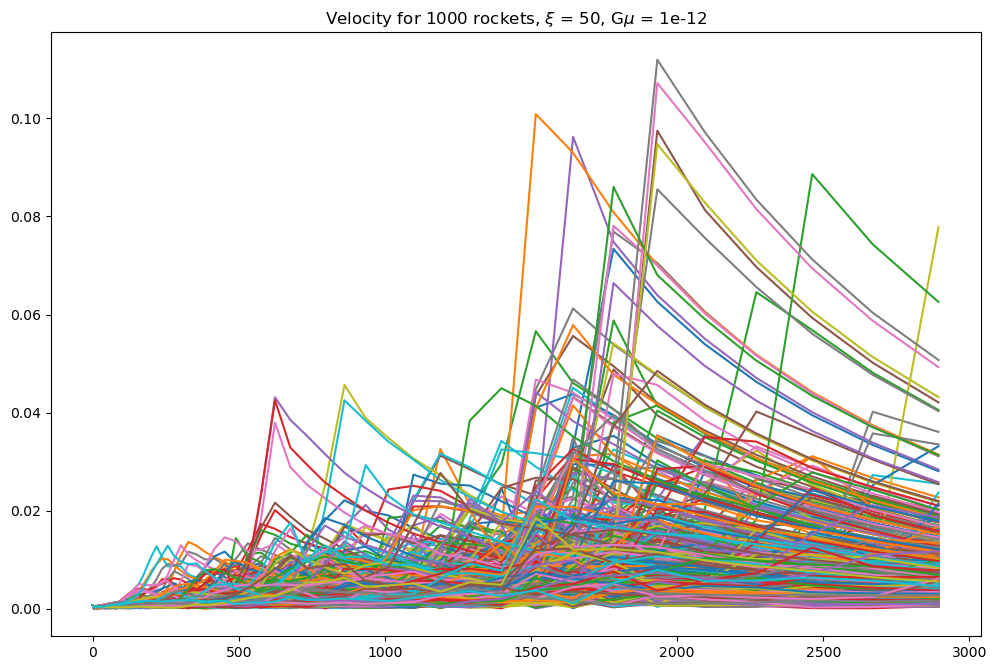

In [30]:
xArr, vArr = np.load(homeDir + "loopEvol_ZoomedIn__num_1000__xi_50.npy")
haloC = getHaloC(tmax)
RVir200, RVir500 = getRVir()

fig = plt.figure(4, figsize=(12, 8), dpi=100)
ax = fig.gca()

[plt.plot(tArr, [np.linalg.norm(xArr[i, :, t] - xArr[i, :, 0]) for t in range(tmax)]) for i in range(xArr.shape[0])]
plt.title(r"Displacement for {} rockets, $\xi$ = {}, G$\mu$ = {}".format(1000, 50, Gmu))
# plt.savefig(homeDir + "loopEvol__num_1000__xi_50" + ".png", dpi=300)
plt.show()

fig = plt.figure(5, figsize=(12, 8), dpi=100)
ax = fig.gca()

[plt.plot(tArr, [np.linalg.norm(vArr[i, :, t]) for t in range(tmax)]) for i in range(xArr.shape[0])]
plt.title(r"Velocity for {} rockets, $\xi$ = {}, G$\mu$ = {}".format(1000, 50, Gmu))
# plt.savefig(homeDir + "loopEvol__num_1000__xi_50" + ".png", dpi=300)
plt.show()

43

In [47]:
zArr[[i for i in range(RVirArr.shape[0]) if RVirArr[i, 0] == np.max(RVirArr[:, 0])][0]]

1.4430764129144937

The Virialization Radius only given after z = 23.297817
The Virialization Redshift (From R200) is: 1.443076
The Virialization Redshift (From R500) is: 0.933129


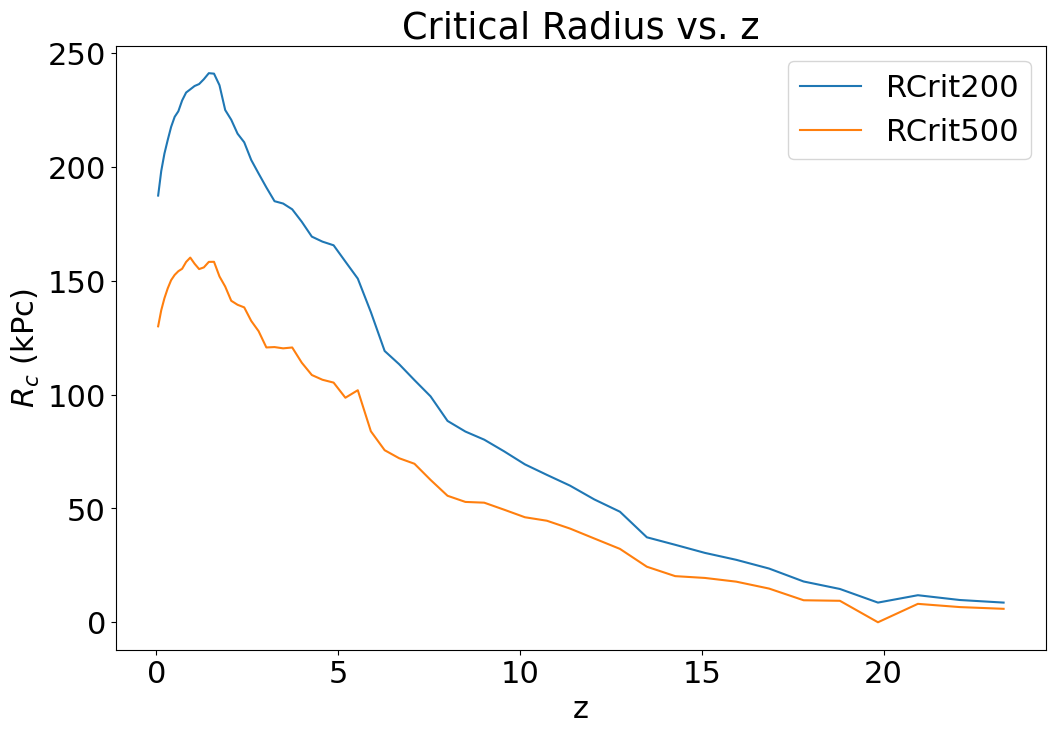

In [9]:
tArr, aArr, HArr = getHubbleEvol()
zArr = 1 / aArr - 1
RVirArr = np.load(homeDir + "RVirArr.npy")
virIdx = [i for i, RVir in enumerate(RVirArr[:, 0]) if RVir > 0][0]
print("The Virialization Radius only given after z = {:f}".format(zArr[virIdx]))
print("The Virialization Redshift (From R200) is: {:f}".format(zArr[[i for i in range(RVirArr.shape[0]) if RVirArr[i, 0] == np.max(RVirArr[:, 0])][0]]))
print("The Virialization Redshift (From R500) is: {:f}".format(zArr[[i for i in range(RVirArr.shape[0]) if RVirArr[i, 1] == np.max(RVirArr[:, 1])][0]]))

fig = plt.figure(6, figsize=(12, 8), dpi=100)
fig.patch.set_facecolor('White')
mpl.rcParams.update({'font.size': 22})
ax = fig.gca()

plt.plot(zArr[virIdx:], 1000 * RVirArr[virIdx:, 0], label="RCrit200")
plt.plot(zArr[virIdx:], 1000 * RVirArr[virIdx:, 1], label="RCrit500")
plt.title(r"Critical Radius vs. z".format(1000, 50, Gmu))
plt.xlabel("z")
plt.ylabel(r"$R_c$ (kPc)")
plt.legend(loc="upper right")
plt.savefig(homeDir + "RCritVsRedshift" + ".png", dpi=300)
plt.show()

In [14]:
haloFinalDir = simDir + "snapdir_{:03d}\\".format(100)
pathArr = np.asarray(os.listdir(haloFinalDir))
haloFinalCoords = np.empty((0, 3))

for pathi in np.arange(0, pathArr.size):
    datGet = "/PartType1/Coordinates"
    try:
        coords = np.asarray(h5py.File(haloFinalDir + pathArr[pathi], 'r')[datGet])
    except KeyError:
        # print("   (Warning! Could not find ptype {:d} for snapshot t = {:d})".format(ptype, t))
        continue
    haloFinalCoords = np.concatenate([haloFinalCoords, coords], axis=0)

haloC = np.asarray([np.mean(haloFinalCoords[:, i]) for i in range(3)])
print("The final center of the Halo is: ({:f} {:f} {:f})".format(*haloC))

The final center of the Halo is: (50.494461 50.433137 50.554281)


In [11]:
meanPaths = np.asarray([np.linalg.norm(xArr[i, :, -1] - xArr[i, :, 0]) for i in range(xArr.shape[0])])
meanPath = np.mean(meanPaths)
print("The Mean Path length is: {:f}".format(meanPath))

The Mean Path length is: 2.840614
